<a href="https://colab.research.google.com/github/tGhattas/DL/blob/master/GAN_MNIST_latent_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from tqdm.keras import TqdmCallback


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
my_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=my_devices, device_type='GPU')
print(my_devices)

[]


In [4]:
latent_dim = 64
noise_sigma = 0.35
sml_train_size = 50 #TODO

# load train and test images, and pad & reshape them to (-1,32,32,1)
(x_train, y_train_numerical), (x_test, y_test_numerical) = mnist.load_data()
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)).astype('float32') / 255.0
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)).astype('float32') / 255.0
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2), (0, 0)))
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2), (0, 0)))
print(x_train.shape)
print(x_test.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


In [5]:
y_train = keras.utils.to_categorical(y_train_numerical, num_classes=10, dtype='float32')
y_test = keras.utils.to_categorical(y_test_numerical, num_classes=10, dtype='float32')

encoder = Sequential()
encoder.add(layers.Conv2D(16, (4, 4), strides=(2, 2), activation='relu', padding='same', input_shape=(32, 32, 1)))
encoder.add(layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Reshape((2 * 2 * 96,)))
encoder.add(layers.Dense(latent_dim))

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
decoder = Sequential()
decoder.add(layers.Dense(2 * 2 * 96, activation='relu', input_shape=(latent_dim,)))
decoder.add(layers.Reshape((2, 2, 96)))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), activation='sigmoid', padding='same'))

autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
#@title Auto Encoder Trainer
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/DL5/AE_model_save/cp.ckpt"
train_AE = False #@param {type:"boolean"}

if train_AE:
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True)
    autoencoder.fit(x_train + noise_sigma * np.random.randn(*x_train.shape), x_train,
                    verbose=0,
                    epochs=15,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[cp_callback, TqdmCallback(verbose=1)])
else:
    autoencoder.load_weights(checkpoint_path)

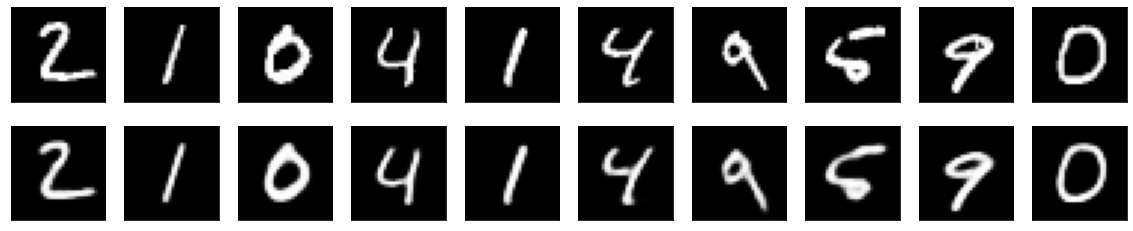

In [7]:
decoded_imgs = autoencoder.predict(x_test)
latent_codes = encoder.predict(x_test)
decoded_imgs = decoder.predict(latent_codes)

def sample_display(n, xs, ys):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(xs[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(ys[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

sample_display(10, x_test, decoded_imgs)

In [8]:
def plot(models, attrs=None):

    for k in attrs or ['val_loss', 'val_accuracy']:
        plt.figure()
        for model in models:
            plt.plot(model.history.history[k], label=model.name)
        plt.title(k.title().replace('_', ' '))
        plt.ylabel('value')
        plt.xlabel('No. epoch')
        plt.legend(loc="upper left")
        plt.show()


Model: "transferred"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total params: 568,842
Trainable params: 568,842
Non-trainable params: 0
_________________________________________________________________
None


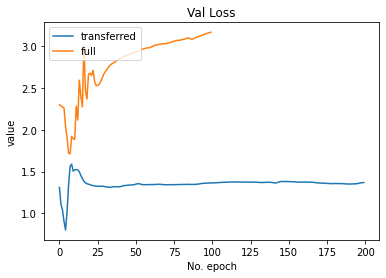

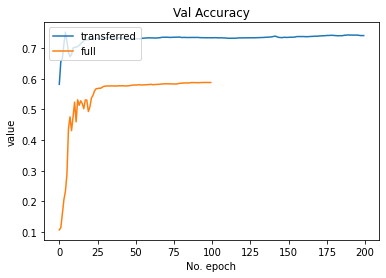

In [9]:
#@title Transfer Learning
    
classifier = Sequential(name='transferred')
classifier.add(layers.Dense(512, activation='relu', input_shape=(latent_dim,)))
classifier.add(layers.Dropout(0.2))
classifier.add(layers.Dense(1024, activation='relu'))
classifier.add(layers.Dense(10, activation='softmax'))

train_codes = encoder.predict(x_train[:sml_train_size])
test_codes = encoder.predict(x_test)

classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(classifier.summary())
classifier.fit(train_codes, y_train[:sml_train_size],
              verbose=0,
              epochs=200,
              batch_size=16,
              shuffle=True,
              validation_data=(test_codes, y_test), callbacks=[TqdmCallback(verbose=1)])

full_cls_enc = keras.models.clone_model(encoder)
full_cls_cls = keras.models.clone_model(classifier)
full_cls = keras.Model(full_cls_enc.inputs, full_cls_cls(full_cls_enc.outputs), name='full')

full_cls.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

full_cls.fit(x_train[:sml_train_size], y_train[:sml_train_size],
            epochs=100,
            verbose=0,
            batch_size=16,
            shuffle=True,
            validation_data=(x_test, y_test),
            callbacks=[TqdmCallback(verbose=1)])

plot([classifier, full_cls])


In [10]:
#@title Generator & Discriminator Definition

# generator
generator_input_dim = 32  # @param {type:"slider", min:0, max:100, step:1}
generator = Sequential(name='generator')
generator.add(layers.Dense(64, input_shape=(generator_input_dim,), activation='relu'))
generator.add(layers.Dense(1024, activation='relu'))
generator.add(layers.Dense(512, activation='relu'))
generator.add(layers.Dense(latent_dim))

# discriminator
consolidator = Sequential(name='discriminator')
consolidator.add(layers.Dense(10, activation='relu', input_shape=classifier.output_shape))
consolidator.add(layers.Dense(1, activation='sigmoid'))
discriminator_1 = tf.keras.Model(classifier.inputs, consolidator(classifier.outputs), name="discriminator")

# discriminator with classification
consolidator = Sequential(name='discriminator')
consolidator.add(layers.Dense(10, activation='relu', input_shape=classifier.output_shape))
consolidator.add(layers.Dense(1, activation='sigmoid'))
discriminator_2 = tf.keras.Model(classifier.inputs, layers.Concatenate(axis=1)([consolidator(classifier.outputs), classifier.outputs[-1]]),
                                 name="discriminator")

In [11]:
#@title GAN Implementaion

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim,
                 with_user_input=False, classifier=None, name='GAN', digit_validity_weight=0.7, train_disc=True):
        super(GAN, self).__init__(name=name)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.with_user_input = with_user_input
        self.digit_validity_weight = digit_validity_weight
        self.train_disc = train_disc

    def compile(self, d_optimizer, g_optimizer, loss_fn, additional_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.additional_loss_fn = additional_loss_fn


    def train_step(self, real_latent_vector):
        """ 
        if with_user_input = True, the real_latent_vector should be a tuple
        (user_input, real_latent_vector) otherwise, its the real_latent_vector
        """

        if self.with_user_input:
          user_input = real_latent_vector[:, :1]
          real_latent_vector = real_latent_vector[:, 1:]

        # Sample random points in the latent space
        batch_size = tf.shape(real_latent_vector)[0]
        random_generator_input = tf.random.normal(shape=(batch_size,
                                                        self.latent_dim - int(self.with_user_input)))
        
        if self.with_user_input:

            random_user_input = tf.dtypes.cast(tf.random.uniform((batch_size,1), 0, 9, dtype=tf.int32), tf.float32)
            random_generator_input = tf.concat([random_user_input,
                                              random_generator_input], axis=1)

            one_hots = tf.one_hot(tf.dtypes.cast(user_input, tf.int32), depth=10)
            one_hots = tf.convert_to_tensor(one_hots)
            real_latent_labels = tf.dtypes.cast(one_hots[:, 0, :], tf.float32)


        # Decode them to fake latent codes
        generated_latent_vectors = self.generator(random_generator_input)

        # Combine them with real AE latent codes
        combined_vecs = tf.concat([generated_latent_vectors, real_latent_vector], axis=0)

        # Assemble labels discriminating real from fake latent code
        label_size = self.discriminator.output_shape[-1]

        if self.with_user_input:
            class_labels = tf.concat(
              [tf.ones(tf.shape(real_latent_labels)), real_latent_labels], axis=0
            )
            
        # Add random noise to the labels
        binary_labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Add random noise to the labels
        binary_labels += 0.05 * tf.random.uniform(tf.shape(binary_labels))

        # Train the discriminator
        if self.train_disc:
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_vecs)
                if not self.with_user_input:
                    d_loss = self.loss_fn(binary_labels, predictions)
                else:
                    bin_predictions = predictions[:, :1]
                    classes_prediction = predictions[:, 1:]
                    d_loss = (1-self.digit_validity_weight) * self.additional_loss_fn(class_labels, classes_prediction)
                    d_loss += self.digit_validity_weight * self.loss_fn(binary_labels, bin_predictions)

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        else:
            predictions = self.discriminator(combined_vecs)
            d_loss = self.loss_fn(binary_labels, predictions)
        # Sample random points in the latent space
        random_generator_input = tf.random.normal(shape=(batch_size,
                                                        self.latent_dim - int(self.with_user_input)))
        if self.with_user_input:
            random_user_input = tf.dtypes.cast(tf.random.uniform((batch_size,1), 0, 9, dtype=tf.int32), tf.float32)
            random_generator_input = tf.concat([random_user_input,
                                              random_generator_input], axis=1)
            
            one_hots = tf.one_hot(tf.dtypes.cast(random_user_input, tf.int32), depth=10)
            one_hots = tf.convert_to_tensor(one_hots)
            random_generator_input_labels = tf.dtypes.cast(one_hots[:, 0, :], tf.float32)

        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generator_output = self.generator(random_generator_input)
            predictions = self.discriminator(generator_output) 
            if not self.with_user_input:
                g_loss = self.loss_fn(misleading_labels, predictions)
            else:
                bin_predictions = predictions[:, :1]
                classes_prediction = predictions[:, 1:]
                g_loss = (1-self.digit_validity_weight) * self.additional_loss_fn(random_generator_input_labels, classes_prediction)
                g_loss += self.digit_validity_weight * self.loss_fn(misleading_labels, bin_predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [12]:
#@title Visualize Generater Some Outputs
def plot_generator_ouputs(gan_):
    samples_num = 20 #@param {type:"integer"}
    # Generate some samples using the trained generator and decod as images with the decoder
    decoded_imgs = []
    for i in range(samples_num):
        rand_vec = tf.random.normal(shape=(1, 32-int(with_user_input)))
        if gan_.with_user_input:
          rand_vec = tf.concat([tf.constant(i%10, dtype=tf.float32, shape=(1,1)),
                                rand_vec], axis=1)
        gen_prediction = gan_.generator.predict(rand_vec)
        gan_.discriminator.predict(gen_prediction)
        decoded_imgs.append(decoder.predict(gen_prediction))
    f, ax = plt.subplots(1, samples_num, figsize=(2*samples_num,10))
    for i, dim in enumerate(decoded_imgs):
      ax[i].imshow(dim.reshape(32, 32))
    plt.gray()
    plt.axis('off')
    plt.show()


In [13]:
class PlotGenOutputsCallback(keras.callbacks.Callback):
    def __init__(self, gen, step=1):
        self.step = step
        self.gen = gen
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.step == 0:
            print(f"End epoch {epoch} of training, plotting Generator results:")
            plot_generator_ouputs(self.gen)

End epoch 0 of training, plotting Generator results:


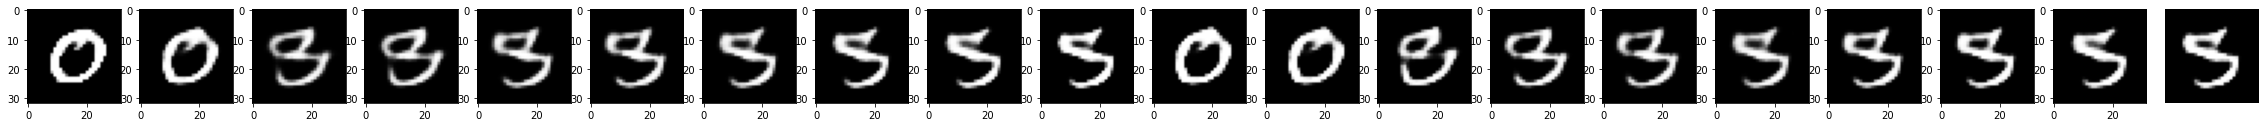

End epoch 40 of training, plotting Generator results:


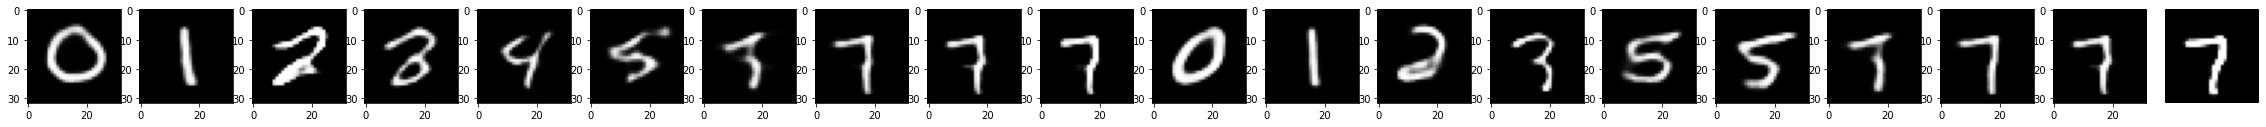

End epoch 80 of training, plotting Generator results:


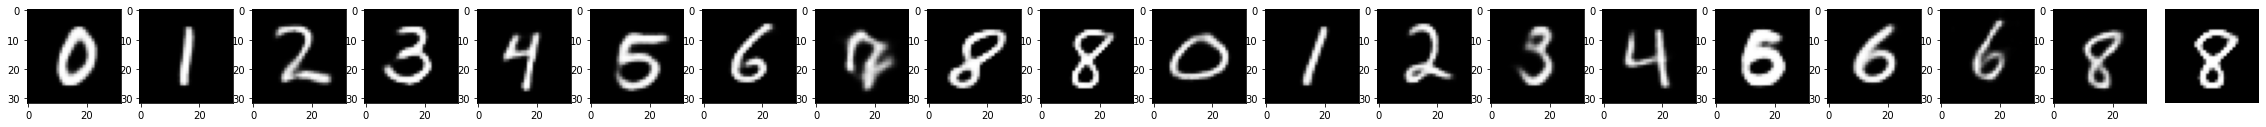

End epoch 120 of training, plotting Generator results:


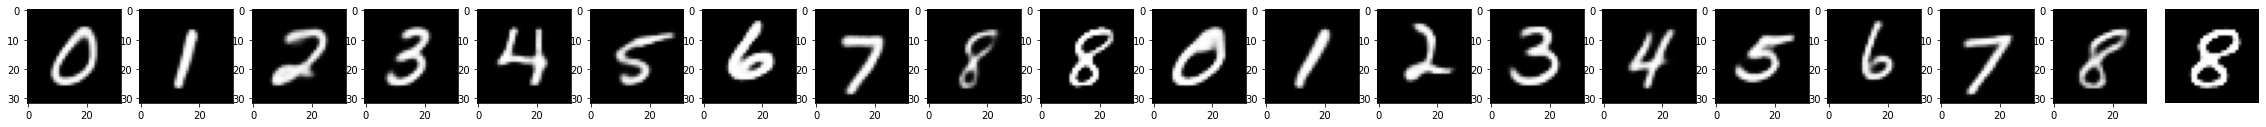

End epoch 160 of training, plotting Generator results:


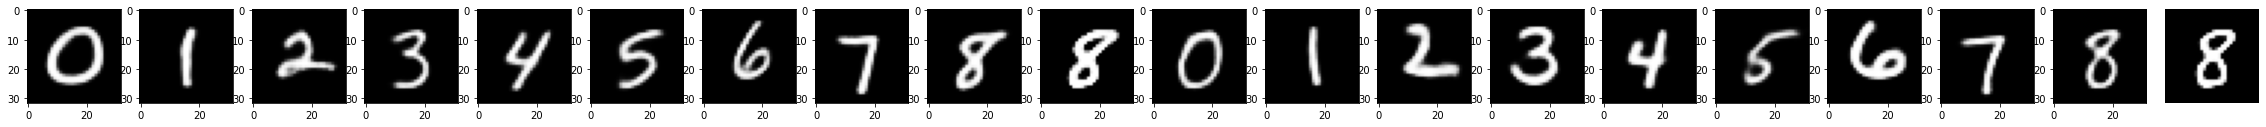

End epoch 200 of training, plotting Generator results:


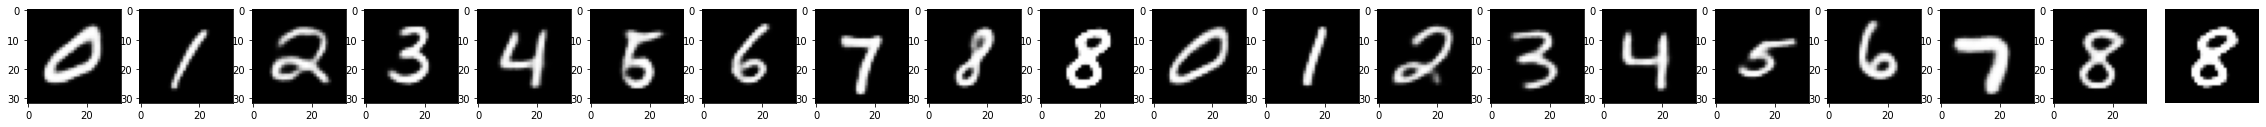

End epoch 240 of training, plotting Generator results:


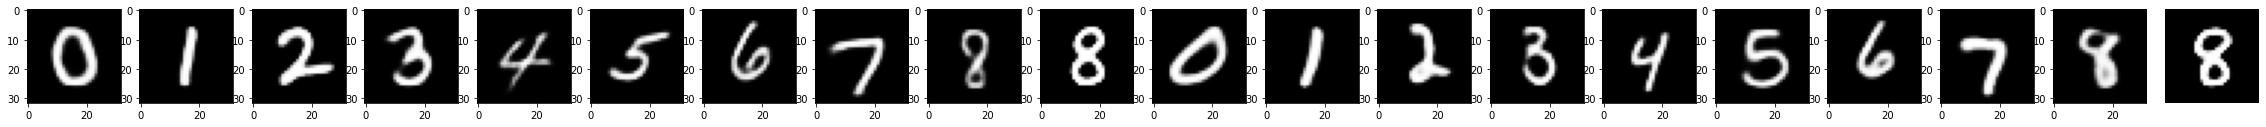

In [14]:
#@title Prepare the dataset & Train
with_user_input = True #@param {type:"boolean"}
load_gan = False  # @param {type:"boolean"}
train_gan = True  # @param {type:"boolean"}
batch_size = 128
encoder_latent_codes = np.concatenate([encoder.predict(x_train), encoder.predict(x_test)])
if with_user_input:
    labels = np.concatenate((y_train_numerical, y_test_numerical))[..., np.newaxis]
    training_vecs = np.concatenate((labels, encoder_latent_codes), axis=1)
    additional_loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    discriminator_ = discriminator_2
else:
    training_vecs = encoder_latent_codes
    additional_loss_fn = None
    discriminator_ = discriminator_1
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
dataset = tf.data.Dataset.from_tensor_slices(training_vecs)
dataset = dataset.shuffle(buffer_size=2048).batch(batch_size)

digit_validity_weight = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

gan = GAN(discriminator_, generator, latent_dim=32,
          with_user_input=with_user_input, 
          digit_validity_weight=digit_validity_weight, name="GAN_1")


gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=loss_fn,
    additional_loss_fn=additional_loss_fn,
)



gan_checkpoint_path_1 = f"/content/drive/MyDrive/Colab Notebooks/DL5/{gan.name}_model_save/cp.ckpt"

if load_gan:
    gan.load_weights(gan_checkpoint_path_1)

epochs_num = 241 #@param {type:"slider", min:5, max:500, step:1}
plotter_on_epochs_step = 40 #@param {type:"slider", min:1, max:100, step:1}

if train_gan:
    checkpoint_dir = os.path.dirname(gan_checkpoint_path_1)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=gan_checkpoint_path_1,
                                                     save_weights_only=True)
    gan.fit(dataset.take(1000), verbose=0, epochs=epochs_num,
            callbacks=[cp_callback,
                       TqdmCallback(verbose=1),
                       PlotGenOutputsCallback(gan, plotter_on_epochs_step)])
  

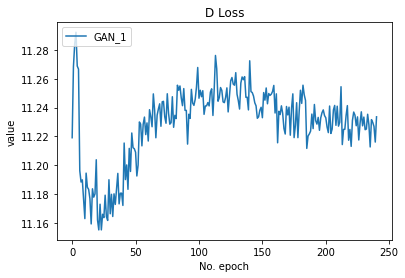

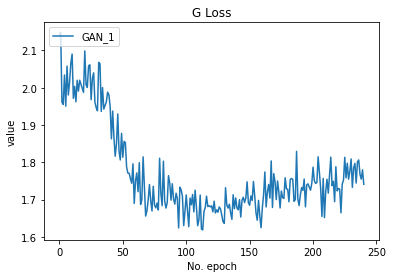

In [15]:
plot([gan], gan.history.history.keys())

In [16]:
#@title Interpolation Plotter
def plot_intorpolation(encoder_, vec_1, vec_2):
    for i in range(4, 16, 1):
        alpha = float(i) / 20.0
        plt.figure(figsize=(12,4))
        f, ax = plt.subplots(1, 3)
        f.suptitle(f'alpha = {alpha}', fontsize=16)

        gen_prediction = encoder_.predict(vec_1)
        img_1 = decoder.predict(gen_prediction)

        combined_vec = alpha * vec_1 + (1-alpha) * vec_2
        gen_prediction = encoder_.predict(combined_vec)
        img_2 = decoder.predict(gen_prediction)

        gen_prediction = encoder_.predict(vec_2)
        img_3 = decoder.predict(gen_prediction)

        ax[0].imshow(img_1.reshape(32, 32))
        ax[1].imshow(img_2.reshape(32, 32))
        ax[2].imshow(img_3.reshape(32, 32))

        plt.gray()
        plt.axis('off')
        plt.show()
    

<Figure size 864x288 with 0 Axes>

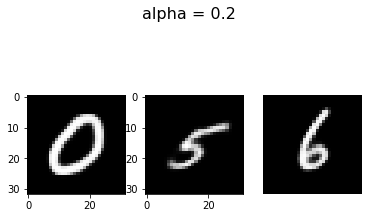

<Figure size 864x288 with 0 Axes>

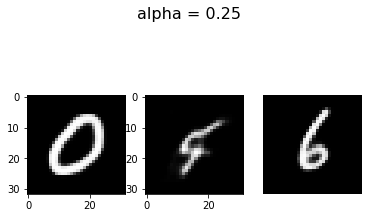

<Figure size 864x288 with 0 Axes>

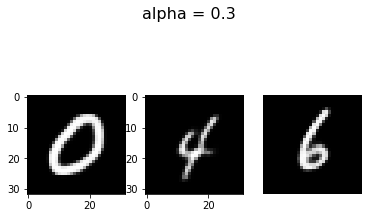

<Figure size 864x288 with 0 Axes>

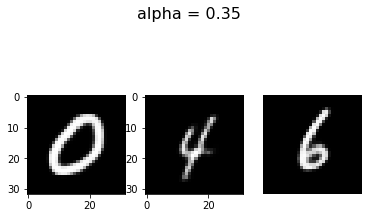

<Figure size 864x288 with 0 Axes>

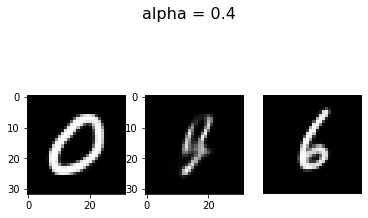

<Figure size 864x288 with 0 Axes>

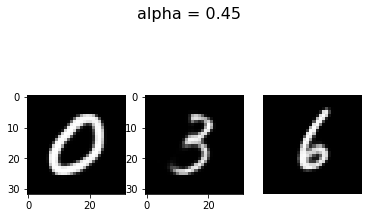

<Figure size 864x288 with 0 Axes>

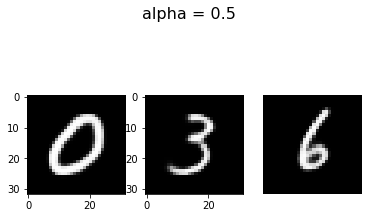

<Figure size 864x288 with 0 Axes>

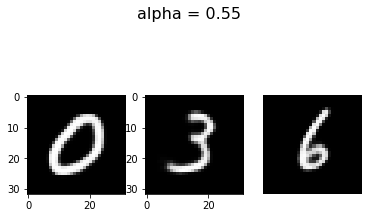

<Figure size 864x288 with 0 Axes>

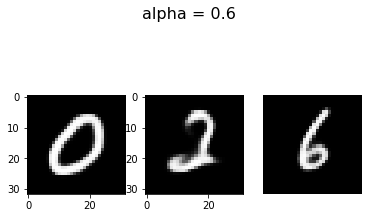

<Figure size 864x288 with 0 Axes>

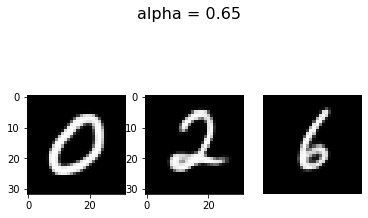

<Figure size 864x288 with 0 Axes>

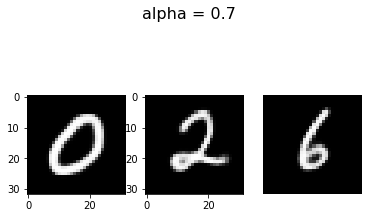

<Figure size 864x288 with 0 Axes>

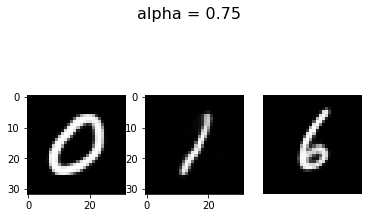

In [17]:
#@title Interpolation within GAN latent code
rand_vec_1 = tf.random.normal(shape=(1, 32-int(gan.with_user_input)))
rand_vec_2 = tf.random.normal(shape=(1, 32-int(gan.with_user_input)))
if gan.with_user_input:
    random_user_input = tf.dtypes.cast(tf.random.uniform((1,2), 0, 9, dtype=tf.int32), tf.float32)
    rand_vec_1 = tf.concat([random_user_input[:, :1],
                                      rand_vec_1], axis=1)
    rand_vec_2 = tf.concat([random_user_input[:, 1:],
                                      rand_vec_2], axis=1)
plot_intorpolation(generator, rand_vec_1, rand_vec_2)

<Figure size 864x288 with 0 Axes>

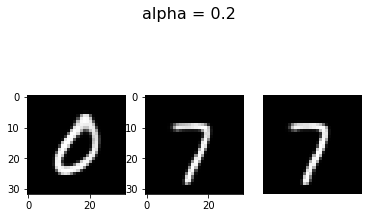

<Figure size 864x288 with 0 Axes>

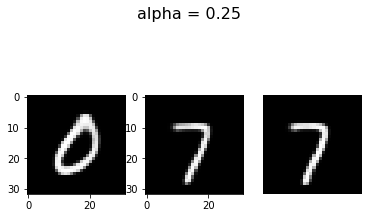

<Figure size 864x288 with 0 Axes>

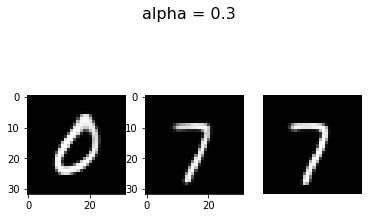

<Figure size 864x288 with 0 Axes>

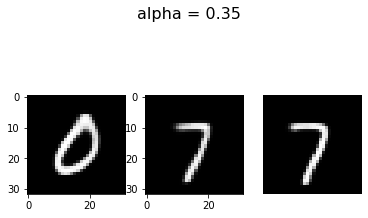

<Figure size 864x288 with 0 Axes>

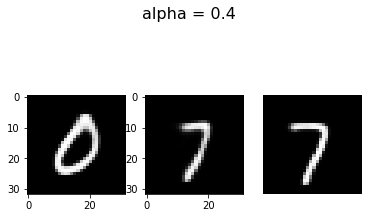

<Figure size 864x288 with 0 Axes>

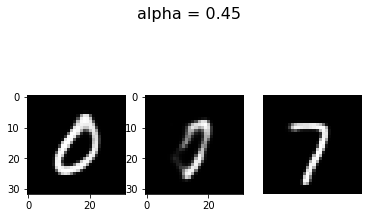

<Figure size 864x288 with 0 Axes>

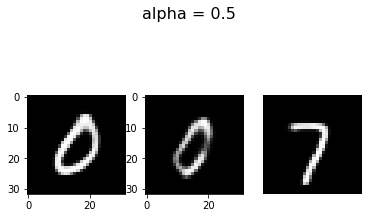

<Figure size 864x288 with 0 Axes>

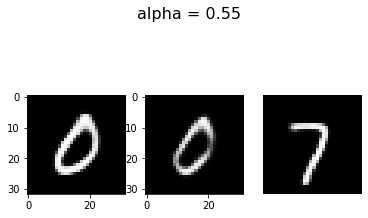

<Figure size 864x288 with 0 Axes>

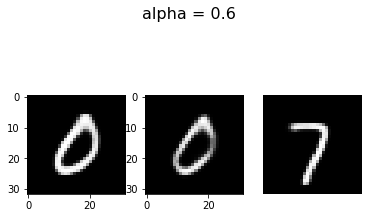

<Figure size 864x288 with 0 Axes>

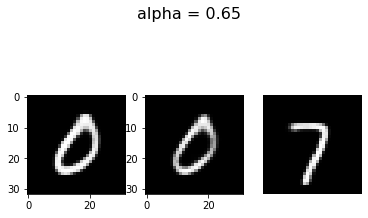

<Figure size 864x288 with 0 Axes>

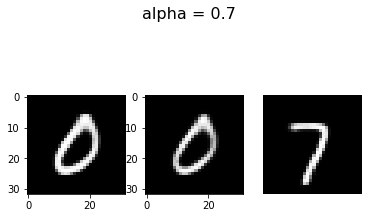

<Figure size 864x288 with 0 Axes>

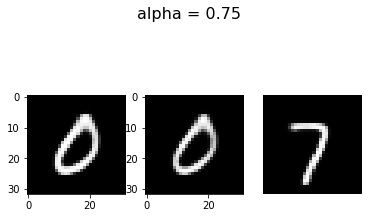

In [18]:
#@title Interpolation within AE latent code
i, j = np.random.choice(range(x_test.shape[0]), 2)
img__1, img__2 = x_test[i:i+1], x_test[j:j+1]
plot_intorpolation(encoder, img__1, img__2)


In [19]:

#@markdown We can see that the GAN latent space interpolation was more robust in the outputs as expected, the GAN sampled from one of the learned distributions rather than averaging them while the encoder of the AE interpolation gave more mixed digits espicially around the middle.
